In [1]:
import os
import sys

In [2]:
# os.system('git clone https://github.com/tikendraw/caption-generator.git -q')
# os.chdir('caption-generator')

In [3]:

import numpy as np
import pandas as pd
import random, math
import tensorflow as tf
import glob
import shutil
from zipfile import ZipFile
import datetime
import sys
from functools import cache
from pathlib import Path
from tqdm import tqdm
import regex as re

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

from sklearn.model_selection import train_test_split


from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocessing
from tensorflow.keras.layers import (
    TextVectorization, Embedding, LSTM, GRU, Bidirectional, TimeDistributed, Dense, Attention, MultiHeadAttention, Flatten, Dropout,
    Concatenate, Activation, GlobalAveragePooling2D
    )
from tensorflow.keras.layers import LSTM, Embedding, Input, Dense, Dropout, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer
from tensorflow import keras
from tensorflow.keras.utils import array_to_img, img_to_array
import string
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping, TensorBoard
from model import LearningRateDecayCallback, get_model, masked_acc, masked_loss
from preprocessing import preprocess_text, embedding_matrix_creater, mapper, clean_words
from utils import create_model_checkpoint

from config import config

from get_data import download_dataset
from funcyou.dataset import download_kaggle_dataset
import polars as pl
from preprocess_data import clean_the_df
from funcyou.utils import printt, dir_walk
import matplotlib.pyplot as plt
from nltk import word_tokenize
import nltk
from collections import Counter
import regex as re
import yaml

2023-05-21 16:33:55.923830: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-21 16:33:57.249475: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-05-21 16:33:59.811719: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-21 16:34:00.019898: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA n

In [4]:
config_file_path = './config.yaml'

# Read the config file 
with open(config_file_path, 'r') as file:
    config = yaml.safe_load(file)


RAW_CAPTION_FILE                        = Path(config['raw_caption_file'])
CAPTION_FILE                            = Path(config['caption_file'])
IMAGE_DIR                               = Path(config['image_dir'])
IMG_SIZE                                = config['img_size']
CHANNELS                                = config['channels']
IMG_SHAPE                               = config['img_shape']
MAX_LEN                                 = config['max_len']
BATCH_SIZE                              = config['batch_size']
EPOCHS                                  = config['epochs']
LEARNING_RATE                           = config['learning_rate']
UNITS                                   = config['units']
TEST_SIZE                               = config['test_size']
VALIDATION_SIZE                         = config['val_size']
EMBEDDING_DIMENSION                     = config['embedding_dimension']
GLOVE_PATH                              = config['glove_path']
D_MODEL                                 = config['d_model']
NUM_HEADS                               = config['num_heads']    
NUM_LAYERS                               = config['num_layers']    
PATCH_SIZE                              = config['patch_size']    
TRANSFORMER_LAYERS                      = config['transformer_layers']        

NUM_PATCHES = (IMG_SIZE // PATCH_SIZE) ** 2 


In [5]:
print(f'''
{      RAW_CAPTION_FILE=}
{CAPTION_FILE=}
{IMAGE_DIR=}
{IMG_SIZE=}
{CHANNELS=}
{IMG_SHAPE=}
{MAX_LEN=}
{BATCH_SIZE=}
{EPOCHS=}
{LEARNING_RATE=}
{UNITS=}
{TEST_SIZE=}
{VALIDATION_SIZE=}
{EMBEDDING_DIMENSION=}
{GLOVE_PATH=}
{D_MODEL=}
{NUM_HEADS=}
{NUM_LAYERS=}
{PATCH_SIZE=}
{TRANSFORMER_LAYERS=}
      ''')


      RAW_CAPTION_FILE=PosixPath('input/flickr30k/results.csv')
CAPTION_FILE=PosixPath('input/flickr30k/results_cleaned.csv')
IMAGE_DIR=PosixPath('input/flickr30k/images')
IMG_SIZE=256
CHANNELS=3
IMG_SHAPE=[256, 256, 3]
MAX_LEN=50
BATCH_SIZE=8
EPOCHS=10
LEARNING_RATE=0.01
UNITS=16
TEST_SIZE=0.05
VALIDATION_SIZE=0.05
EMBEDDING_DIMENSION=50
GLOVE_PATH='embedding/glove.6B.50d.zip'
D_MODEL=128
NUM_HEADS=4
NUM_LAYERS=4
PATCH_SIZE=42
TRANSFORMER_LAYERS=8
      


In [30]:
IMG_SIZE = 128
BATCH_SIZE = 8
IMG_SHAPE = (128,128,3)
D_MODEL = 32
MAX_LEN = 30
PATCH_SIZE = 32
NUM_PATCHES = (IMG_SIZE // PATCH_SIZE) ** 2
NUM_PATCHES

16

In [31]:
START_TOKEN = 'startseq'
END_TOKEN = 'endseq'

# Curating Dataframe

1. Null/Bad Entries removed
2. Columns names stripped and lowered
3. Low frequency word (<5) has been removed 
4. Added start and end tokens

we are keeping words in comments which atleast has occured  5 times( there are unnecessary word which we don't want) 
there are ~12000 words that doesn't even gets repeated 5 times in 150000 lines

In [32]:
clean_the_df(RAW_CAPTION_FILE, '.')

In [33]:
df = pl.read_csv('cleaned.csv')
df.head()

image_name,comment_number,comment,no_rare_words,sent_len
str,i64,str,bool,i64
"""1000092795.jpg…",0,"""startseq Two …",true,18
"""1000092795.jpg…",1,"""startseq Two …",true,11
"""1000092795.jpg…",2,"""startseq Two …",true,12
"""1000092795.jpg…",3,"""startseq A ma…",true,12
"""1000092795.jpg…",4,"""startseq Two …",true,7


delete before this code 


In [34]:
import polars as pd

In [35]:
df = pd.read_csv('cleaned.csv')

try:
    df.drop('Unnamed: 0',axis=1, inplace=True)
except:
    pass

In [36]:
print(df.shape)
print(df.to_pandas().info())
print(df.columns)

(158914, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158914 entries, 0 to 158913
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   image_name      158914 non-null  object
 1   comment_number  158914 non-null  int64 
 2   comment         158914 non-null  object
 3   no_rare_words   158914 non-null  bool  
 4   sent_len        158914 non-null  int64 
dtypes: bool(1), int64(2), object(2)
memory usage: 5.0+ MB
None
['image_name', 'comment_number', 'comment', 'no_rare_words', 'sent_len']


### **For the Sake of COmputation power and time we will train with one caption per image rather than 5 caption per image**

Finding median sentence length for all class of comment numbers, to ensure that our MAX_LEN covers all of them

In [37]:
df = df.with_columns([
    pl.col("image_name").apply(lambda x: str(IMAGE_DIR / x) ).alias('image_path') 
])

df = df.with_columns([
    pl.col("image_path").apply(lambda x: os.path.isfile(x)).alias('img_exists') 
])

df.head()

image_name,comment_number,comment,no_rare_words,sent_len,image_path,img_exists
str,i64,str,bool,i64,str,bool
"""1000092795.jpg…",0,"""startseq Two …",true,18,"""input/flickr30…",true
"""1000092795.jpg…",1,"""startseq Two …",true,11,"""input/flickr30…",true
"""1000092795.jpg…",2,"""startseq Two …",true,12,"""input/flickr30…",true
"""1000092795.jpg…",3,"""startseq A ma…",true,12,"""input/flickr30…",true
"""1000092795.jpg…",4,"""startseq Two …",true,7,"""input/flickr30…",true


In [38]:
# Group by a categorical column
grouped = df.groupby('comment_number')

# Apply aggregation functions on numerical columns
aggregated = grouped.agg(
    pl.col('sent_len').mean().alias('mean'), 
    pl.col('sent_len').median().alias('median'), 
    pl.col('sent_len').min().alias('min'), 
    pl.col('sent_len').max().alias('max'), 
    pl.col('sent_len').count().alias('count')
)
aggregated

comment_number,mean,median,min,max,count
i64,f64,f64,i64,i64,u32
0,19.871315,19.0,6,79,31783
1,15.859327,15.0,6,41,31783
2,13.602869,13.0,4,34,31783
3,11.771639,11.0,4,36,31783
4,9.871437,10.0,3,38,31782


In [39]:
# i randomly chose 2nd comment of all picture you can chose anything bw 0 to 4
df = df.filter(
    (pl.col("comment_number") == 1) & (pl.col("img_exists") == True) & (pl.col("sent_len") < 51)
)
df.shape

(31783, 7)

now we are just using 1/5 dataset

# Tokenize

In [40]:
def preprocess_text(text):

    text = tf.strings.lower(text)

    text = tf.strings.regex_replace(text, r'\d', '')

    # Remove any punctuations
    text = tf.strings.regex_replace(text, '[%s]' % re.escape(
        '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'), '')

    # Remove single characters
    text = tf.strings.regex_replace(text, r'\b\w\b', '')
    # Keep space, a to z, and select punctuation.
    text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
    # Add spaces around punctuation.
    text = tf.strings.regex_replace(text, '[.?!,¿|]', r' \0 ')
    # Strip whitespace.
    text = tf.strings.strip(text)

    return text


In [41]:

#tokenizer
tokenizer = TextVectorization(standardize=preprocess_text)
tokenizer.adapt(df['comment'].to_list())


word_to_id = tf.keras.layers.StringLookup(vocabulary=tokenizer.get_vocabulary(), mask_token='', oov_token='[UNK]')
id_to_word = tf.keras.layers.StringLookup(vocabulary=tokenizer.get_vocabulary(), mask_token='', oov_token='[UNK]', invert=True)


# making Dataset

In [42]:

def mapper(x, y, tokenizer):
    x = load_images_now(x)
    y = tokenizer(y)

    y_in = y[:-1]
    y_in =  tf.pad(y_in, [[0, MAX_LEN - tf.shape(y_in)[0]]] , constant_values=0)

    y_out = y[1:]
    y_out =  tf.pad(y_out, [[0, MAX_LEN - tf.shape(y_out)[0]]], constant_values=0)

    return (x, y_in), y_out


@tf.function
def load_images_now(x):
    image_data = tf.io.read_file(x)
    image_features = tf.image.decode_jpeg(image_data, channels=CHANNELS)
    image_features = tf.image.resize_with_pad(
        image_features, target_height=IMG_SIZE, target_width=IMG_SIZE)
    return image_features


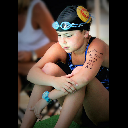

In [43]:
random_image_filepath = random.choices(df['image_path'].to_list(), k=1)[0]
p_image = load_images_now(str(random_image_filepath))
array_to_img(p_image)

In [44]:
# Creating dataset
TEST_SIZE = config['test_size']
VAL_SIZE =  config['val_size']

train, val = train_test_split(
    df[['image_path', 'comment']],  test_size=VAL_SIZE, random_state=11)
train, test = train_test_split(
    train[['image_path', 'comment']],  test_size=TEST_SIZE, random_state=11)

train_data = tf.data.Dataset.from_tensor_slices((train['image_path'].to_list(), train['comment'].to_list()))
test_data = tf.data.Dataset.from_tensor_slices((test['image_path'].to_list(), test['comment'].to_list()))
val_data = tf.data.Dataset.from_tensor_slices((val['image_path'].to_list(), val['comment'].to_list()))


train_data = train_data.map(lambda x,y:mapper(x, y, tokenizer)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_data =   test_data.map(lambda x,y:mapper(x, y, tokenizer)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_data =     val_data.map(lambda x,y:mapper(x, y, tokenizer)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# resnet_output_flattened_shape = 8*8*2048

print("Number of training samples: %d" %
      tf.data.experimental.cardinality(train_data))
print("Number of validation samples: %d" %
      tf.data.experimental.cardinality(val_data))
print("Number of test samples: %d" %
      tf.data.experimental.cardinality(test_data))

VOCAB_SIZE = tokenizer.vocabulary_size()
print("Vocabulary size: %d" % VOCAB_SIZE)


Number of training samples: 3586
Number of validation samples: 199
Number of test samples: 189
Vocabulary size: 7102


2023-05-21 16:36:02.231331: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'args_0' with dtype string
	 [[{{node args_0}}]]
2023-05-21 16:36:02.290348: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'args_0' with dtype string
	 [[{{node args_0}}]]
2023-05-21 16:36:02.349749: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'args_0' with dtype string
	 [[{{node args_0}}]]


In [45]:
train.shape, len(train_data)*BATCH_SIZE

((28683, 2), 28688)

In [46]:
for (img_in, txt_in), txt_out in train_data.take(1):
    # print(f'{i.numpy().decode():<40} {j.numpy()}')
    print('x     : ', img_in.shape)
    print('y_in.shape(one batch)  : ', txt_in.shape)
    
    print('y_in  : ', txt_in[0])
    
    print('y_out.shape(one batch)  : ', txt_out.shape)
    print('y_out : ', txt_out[0])
    print('\n')


x     :  (8, 128, 128, 3)
y_in.shape(one batch)  :  (8, 30)
y_in  :  tf.Tensor(
[   2 1710   31    8  580    6    4  192   11   56    9  326  251    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0], shape=(30,), dtype=int64)
y_out.shape(one batch)  :  (8, 30)
y_out :  tf.Tensor(
[1710   31    8  580    6    4  192   11   56    9  326  251    3    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0], shape=(30,), dtype=int64)




2023-05-21 16:36:02.459565: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64
	 [[{{node Placeholder/_4}}]]


# Model

In [52]:
from transformer import CaptionGenerator, Encoder, Decoder

In [53]:
enc = Encoder( NUM_LAYERS, D_MODEL, NUM_HEADS, DFF, PATCH_SIZE, NUM_PATCHES, dropout_rate=0.1)
dec = Decoder( NUM_LAYERS, D_MODEL, NUM_HEADS, DFF, VOCAB_SIZE, dropout_rate=0.1)

: 

: 

In [47]:
MAX_LEN

30

In [49]:
DFF = 1024

In [50]:
model = CaptionGenerator(NUM_LAYERS, D_MODEL, NUM_HEADS, DFF, VOCAB_SIZE, PATCH_SIZE, NUM_PATCHES, dropout_rate=0.1)

In [51]:
output = model((img_in, txt_in))

TensorShape([16])
attn_output:  TensorShape([8, 16, 32])
concat:  TensorShape([8, 16, 32])


2023-05-21 16:36:03.522897: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:417] Loaded runtime CuDNN library: 8.1.0 but source was compiled with: 8.6.0.  CuDNN library needs to have matching major version and equal or higher minor version. If using a binary install, upgrade your CuDNN library.  If building from sources, make sure the library loaded at runtime is compatible with the version specified during compile configuration.
2023-05-21 16:36:03.523940: W ./tensorflow/compiler/xla/stream_executor/stream.h:1583] attempting to perform DNN operation using StreamExecutor without DNN support


InternalError: Exception encountered when calling layer 'layer_normalization_32' (type LayerNormalization).

{{function_node __wrapped__FusedBatchNormV3_device_/job:localhost/replica:0/task:0/device:GPU:0}} cuDNN launch failure : input shape ([1,128,32,1]) [Op:FusedBatchNormV3]

Call arguments received by layer 'layer_normalization_32' (type LayerNormalization):
  • inputs=tf.Tensor(shape=(8, 16, 32), dtype=float32)

In [26]:
ss = tf.random.uniform((8,36,128))
ss.shape

TensorShape([8, 36, 128])

In [27]:
ln = tf.keras.layers.LayerNormalization()
sss = ln(ss)
sss.shape

2023-05-21 16:13:50.042305: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:417] Loaded runtime CuDNN library: 8.1.0 but source was compiled with: 8.6.0.  CuDNN library needs to have matching major version and equal or higher minor version. If using a binary install, upgrade your CuDNN library.  If building from sources, make sure the library loaded at runtime is compatible with the version specified during compile configuration.
2023-05-21 16:13:50.045576: W ./tensorflow/compiler/xla/stream_executor/stream.h:1583] attempting to perform DNN operation using StreamExecutor without DNN support


InternalError: Exception encountered when calling layer 'layer_normalization_32' (type LayerNormalization).

{{function_node __wrapped__FusedBatchNormV3_device_/job:localhost/replica:0/task:0/device:GPU:0}} cuDNN launch failure : input shape ([1,288,128,1]) [Op:FusedBatchNormV3]

Call arguments received by layer 'layer_normalization_32' (type LayerNormalization):
  • inputs=tf.Tensor(shape=(8, 36, 128), dtype=float32)

In [ ]:

def masked_loss(y_true, y_pred):
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        reduction='none')
    loss = loss_fn(y_true, y_pred)

    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask

    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

def masked_acc(y_true, y_pred):
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)

    matchh = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)

    return tf.reduce_sum(matchh)/tf.reduce_sum(mask)


In [ ]:
print(LEARNING_RATE)

0.01


In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
              loss=masked_loss,
              metrics=[masked_acc])


In [ ]:
model.load_weights(f'model_weights/best_so_far/')

In [ ]:
os.makedirs('log', exist_ok=True)
csv_logger = CSVLogger('./log/training.log',append=True )
tb_callback = tf.keras.callbacks.TensorBoard('./logs', update_freq=1)

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [ ]:
EPOCHS = 360
print(len(train_data) // EPOCHS, len(val_data) // EPOCHS)

# steps_per_epoch = int(1*(len(train_data) / EPOCHS))
# validation_steps =  int(1*(len(val_data) / EPOCHS))
# print(steps_per_epoch, validation_steps)

steps_per_epoch = 20
validation_steps = 1
print(steps_per_epoch, validation_steps)


9 0
20 1


In [ ]:
len(train_data), len(val_data), len(test_data)

(3586, 199, 189)

In [ ]:
{"expected_loss": np.log(VOCAB_SIZE),
 "expected_acc": 1/VOCAB_SIZE}

{'expected_loss': 8.829079952564836, 'expected_acc': 0.00014641288433382137}

## model.fit

In [ ]:
history = model.fit(train_data.repeat(),
                    epochs=EPOCHS,
                    validation_data=val_data,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps,
                    callbacks=[
                        # decay_callback,
                        csv_logger,
                        create_model_checkpoint(model_name = 'capgen', save_dir = 'checkpoints', monitor = 'masked_acc'),
                        tensorboard_callback
                                ]
                    )

Epoch 1/360
20/20 [==============================] - 120s 5s/step - loss: 8.8291 - masked_acc: 0.0012 - val_loss: 8.8291 - val_masked_acc: 0.0000e+00
Epoch 2/360
20/20 [==============================] - 63s 3s/step - loss: 8.8291 - masked_acc: 0.0000e+00 - val_loss: 8.8291 - val_masked_acc: 0.0000e+00
Epoch 3/360
20/20 [==============================] - 68s 4s/step - loss: 8.8291 - masked_acc: 0.0011 - val_loss: 8.8291 - val_masked_acc: 0.0000e+00
Epoch 4/360
20/20 [==============================] - 64s 3s/step - loss: 8.8291 - masked_acc: 0.0000e+00 - val_loss: 8.8291 - val_masked_acc: 0.0000e+00
Epoch 5/360
20/20 [==============================] - 71s 4s/step - loss: 8.8291 - masked_acc: 0.0011 - val_loss: 8.8291 - val_masked_acc: 0.0000e+00
Epoch 6/360
20/20 [==============================] - 68s 4s/step - loss: 8.8291 - masked_acc: 0.0000e+00 - val_loss: 8.8291 - val_masked_acc: 0.0000e+00
Epoch 7/360
20/20 [==============================] - 68s 4s/step - loss: 8.8315 - masked_acc:

KeyboardInterrupt: 

In [ ]:
from funcyou.plot import plot_history

In [ ]:
plot_history(history,plot = ['loss','masked_acc'], split = ['train','val'], )

NameError: name 'history' is not defined

In [ ]:
# %tensorboard --logdir logs/gradient_tape


## Saving the Model

In [ ]:
from datetime import datetime

In [ ]:
# model.save(f'saved_model/best-{datetime.now()}-{EPOCHS}.h5')
# model.save_weights(f'model_weights/best_so_far_final/')

In [ ]:
!ls saved_model

In [ ]:
!ls -la -h 'saved_model/'

# Prediction

In [ ]:
pred = model.predict(test_data.take(1))
print(pred.shape)

In [ ]:
ppred = tf.argmax(pred, axis = -1)
print(ppred.shape)

In [ ]:
for i in ppred:
    print(tf.strings.join(id_to_word(i), ' ').numpy())
    print('')